In [1]:
import numpy as np
import math
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [96]:
def prob1(t):
    return 1-(2**(-t/(3.052*60)))
def prob2(t):
    return (2**(-t/(3.052*60)))*(np.log(2)/(3.052*60))
def inv_prob2(prob):
    return -(3.052*60)*np.log2(prob)

def lcg(m=2**32, a=1103515245, c=12345):
    lcg.current = (a*lcg.current + c) % m
    return lcg.current/m
lcg.current = 12345

In [104]:
#Prepare all arrays
time = np.arange(0,3.05*60*2)
Tl1 = prob1(time)
Tl2 = prob2(time)



In [112]:
Tl1_count = np.zeros(1)
Tl2_count = np.zeros(1)

Tl1_count[0] = 1000
Tl2_count[0] = 1000
a = 0

while Tl1_count[a] > 0 or Tl2_count[a] > 0:
    c1 = 0
    c2 = 0
    if Tl1_count[a] > 0:
        for i in range(int(Tl1_count[a])):
            d = lcg()
            if d < prob1(a): c1 = c1+1

    if Tl2_count[a] > 0:
        for i in range(int(Tl2_count[a])):
            d = lcg()
            if d < np.sum(prob2(np.arange(a))): c2 = c2+1

    Tl1_count = np.append(Tl1_count,Tl1_count[a]-c1)
    Tl2_count = np.append(Tl2_count,Tl2_count[a]-c2)
    a=a+1



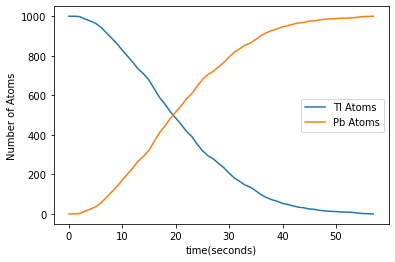

In [113]:
PB1_count = abs(Tl1_count-1000)
PB2_count = abs(Tl2_count-1000)


plt.plot(np.arange(np.size(Tl1_count)),Tl1_count,label="Tl Atoms")
plt.plot(np.arange(np.size(Tl1_count)),PB1_count,label="Pb Atoms")
plt.legend();
plt.xlabel("time(seconds)");
plt.ylabel("Number of Atoms");

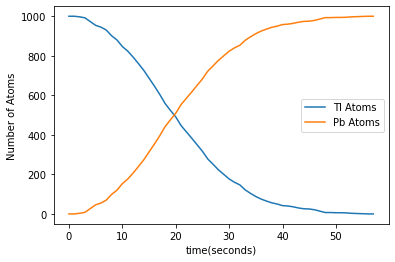

In [114]:
plt.plot(np.arange(np.size(Tl2_count)),Tl2_count,label="Tl Atoms")
plt.plot(np.arange(np.size(Tl2_count)),PB2_count,label="Pb Atoms")
plt.xlabel("time(seconds)");
plt.ylabel("Number of Atoms");
plt.legend();


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

Solution: We replace theta for pi/2 in the scattering angle equation to see what b values are the ones who bounce back:

$$
\tan{\frac{1}{2} \frac{\pi}{2}} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

From that we get that b must be smaller than:

$$
{b} < \frac{Z e^2} {2\pi \epsilon_0 E }
$$

In [144]:
a0 = 5.29177249e-11
Z = 79
E=7.7*1.609e-13
num = 1e7
electron = 1.602176634e-19
e0 = 8.85418781e-12


def b_gen():
    z = np.random.random()*(a0/100)
    r_squared = -2*np.log(1-z)
    return np.sqrt(r_squared)



b_bounce = (Z* electron**2)/(2*np.pi*e0*E)
c = 0
for i in range(int(num)):
    if b_gen() < b_bounce:
        c = c+1

print("The particles who bounce back are: ", c, "Representing the ", c/num,"% of the population")




The particles who bounce back are:  986 Representing the  9.86e-05 % of the population


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [5]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

In [6]:
# Monte Carlo integration
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print(I)

1.45258


In [57]:
def mc_integrate(func, a, b, n):
    # Monte Carlo integration between x1 and x2 of given function from a to b

    vals = np.random.uniform(a, b, n)
    y = [func(val) for val in vals]

    y_mean = np.sum(y)/n
    integ = (b-a) * y_mean

    return integ

mc_integrate(f,0,2,int(N))

1.4518238418993297

Wolfram Alpha set 1.4514 as a result of the Integral, meaning the mean value method was closer to that result using the same N

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [14]:
def f_circle(x,y):
    if x**2+y**2 <=1: awns = 1
    else: awns = 0
    return awns

In [28]:
def f_sphere(d):
    a = np.random.random(d)
    suma = 0
    for i in a:
        suma = i*i+suma
    if suma <=1:
        awns = 1
    else: awns = 0
    return awns


In [51]:
def mc_integrate2(func, a, b, n):
    # Monte Carlo integration between x1 and x2 of given function from a to b
    vals1 = np.random.uniform(a, b, n)
    vals2 = np.random.uniform(a, b, n)
    y = [func(vals1[a],vals2[a]) for a in range(n)]

    y_mean = np.sum(y)/n
    integ = (b-a) * y_mean

    return integ

print("Mean method result:",mc_integrate2(f_circle,-1,1,N), "Wolfram Alpha result: 1.5707964")


Mean method result: 1.56916 Wolfram Alpha result: 1.5707964


In [50]:
def mc_integratesp(func, a, b, n):
    # Monte Carlo integration between x1 and x2 of given function from a to b

    y = [func(10) for a in range(n)]
    #print(y)
    y_squared = [k ** 2 for k in y]
    y_mean = np.sum(y_squared)/n
    integ = ((b-a)**10) * y_mean

    return integ


print("Mean method result:",mc_integratesp(f_sphere,-1,1,10000000), "Wolfram Alpha result: 2.5501640")

Mean method result: 2.5604096 Wolfram Alpha result: 2.5501640


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

We have f =
$$
f(x)= \frac{x^{-1/2}}{e^x+1} = \frac{1}{(e^x+1) \sqrt{x}
$$
So we can get g by dividing f and w together:

$$
g(x)= \frac{1}{(e^x+1) \sqrt{x}} * \sqrt{x}
$$
$$
g(x) = \frac{1}{(e^x+1)}
$$

In [52]:
def f5(x):
    return (x**(-1/2))/(np.exp(x)+1)

def w(x):
    return 1/np.sqrt(x)

def g(x):
    return 1/(np.exp(x)+1)

In [61]:
N = 1e7
x_test = np.random.random(int(N))

I = 1/(2*N) * np.sum(g(x_test))* mc_integrate(w,0,1,int(N))
I

0.8387747700827124